In [268]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


words = open('names.txt', 'r').read().splitlines()
# Create the dataset
chars = sorted(list(set(''.join(words)))) #lists all the unique characters in our names (it's just the lowercase alphabet + a few special characters)
stoi = {s:i+1 for i,s in enumerate(chars)} # this creates a dictionary of values assigned to the characters (0-25)
stoi['&'] = 0 # adding key-value pair to represent the start or end
itos = {i:s for s,i in stoi.items()} # constructing a reverse dictionary to convert integers to characters

block_size = 3 # we are adding a context of 3 characters to try and improve our predictions

X, Y = [], []
for w in words[:5]:
    chs = ['&'] + list(w) + ['&']
    context = [0] * block_size
    for ch in w + '&':
        ix = stoi[ch] # convert the first character in the bigram to its corresponding integer code
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
n = len(X)
# This code gives us X, a n * 3 tensor where n is the number of characters, each with 3 context elements (the three characters before it)
# It also gives us Y, the n tensor of the character that follows the context from X, used for labelling our predictions

&&& ---> a
&&a ---> a
&aa ---> l
aal ---> i
ali ---> y
liy ---> a
iya ---> h
yah ---> &
&&& ---> a
&&a ---> a
&aa ---> r
aar ---> e
are ---> n
ren ---> &
&&& ---> a
&&a ---> a
&aa ---> r
aar ---> i
ari ---> k
rik ---> a
ika ---> &
&&& ---> a
&&a ---> a
&aa ---> r
aar ---> o
aro ---> n
ron ---> &
&&& ---> a
&&a ---> a
&aa ---> r
aar ---> t
art ---> j
rtj ---> a
tja ---> n
jan ---> &


In [221]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([35, 3]), torch.int64, torch.Size([35]), torch.int64)

In [222]:
# Start of the forward pass with explanations:

# Time to make the embeddings for each possible input character (a-z + special characters + & = 32)
C = torch.randn(32, 2)
# Creates a randomised 32x2 tensor of floats, eventually this will give the semantic meaning of each character in 2 dimensions
C

tensor([[ 1.8574,  0.5623],
        [-0.0283,  0.2845],
        [-0.3804,  1.4243],
        [ 0.4341, -0.3705],
        [-0.6409,  0.5280],
        [ 1.9478,  0.4139],
        [ 0.3081, -0.4918],
        [-0.9847,  3.2403],
        [ 0.5339, -1.3270],
        [-0.8066, -0.9659],
        [ 1.1379, -0.2471],
        [ 0.6109, -0.0892],
        [ 0.6801,  1.0716],
        [ 0.3118, -0.4842],
        [ 0.4405,  0.3705],
        [-0.6029, -0.0157],
        [-1.4054, -0.3364],
        [-1.1616, -0.0765],
        [-0.4631,  0.2529],
        [-1.1752,  1.1175],
        [ 0.0390,  0.1657],
        [-1.2002, -0.3327],
        [-0.3262,  1.2207],
        [-1.9598,  0.3188],
        [ 0.6085, -0.8702],
        [ 0.5903,  0.1651],
        [-0.6233, -1.1578],
        [ 0.1482,  1.0501],
        [ 0.4443, -0.6289],
        [ 0.8312,  1.2267],
        [-1.3161, -1.4766],
        [ 1.7797,  0.3724]])

In [210]:
# How do we embed our nx3 context tensor into this embedding tensor (32x2)
emb = C[X] # like this, this gives us a nx3x2 tensor of embeddings
# n = number of 3 character input contexts, 3 = the three characters of each input context, 2 = 2d embedding of each
# character of each context
emb.shape

torch.Size([35, 3, 2])

In [396]:
# lets make the hidden layer, by applying weights (W1) to the initial embeddings
W1 = torch.randn(6, 100) # this makes us a 6x100 tensor, with 100 random weights for each of the 6 input neurons
# (2 dimensions of the three context characters) one weight for each connection to the 100 neurons in the hidden later 
# You always need (number of input neurons (6) * number of output neurons (100) = 600) weights to account for every connection
b1 = torch.randn(100) # these are the biases to be applied to each of the hidden layer neurons

# So, to create the hidden later, we want to multiply each of the six input neurons by their 100 corresponding weights, then 
# sum the 6 results that will be gotten for each 100 hidden neurons, before adding the 100 biases, one for each hidden neuron

# So we want to do this: emb @ W1 + b1

# Part of this will involved multiplying the embeddings (nx3x2) by the weights (6x100). To do this we need to convert the nx3x2
# embeddings to a nx6:
# torch.cat(torch.unbind(emb, 1), 1) # we get a nx6 tensor, the 6 combines the 2 embeddings for the 3 context characters in n
# concat.view(7, 30), .view() can reshape a tensor as long as the total number of data points is the same (30 * 7 = 35 * 6), n = 35 atm
concat = emb.view(n, 6) # this is a the best way to convert to nx6 from nx3x2, more efficient as it doesn't create a new tensor
# Note: for my own understanding, think of 35x3x2 as being 35 groups of 3 groups of 2 data points

h = torch.tanh(concat @ W1 + b1) # this creates a hidden layer for each example in n, multiplying and summing all weights across all 
# neurons and adding the biases, done for every example. tanh is inlcuded to ensure all outputs are between -1 and 1
h.shape

torch.Size([32, 100])

In [212]:
# Now to create the output layer, with 32 neurons for all possible next characters
W2 = torch.randn(100, 32) # random weights for all connections between hidden layer and output layer
b2 = torch.randn(32) # random biases for all output neurons

In [365]:
logits = h @ W2 + b2 #logits are the output neuron activations


# Below is the loss calculation from the logits, which we have replaced with cross_entropy which does the same thing:

# counts = logits.exp() # exponentiate to get fake counts as before
# probs = counts / counts.sum(1, keepdims=True) # softmax for probability distributions
# # Now we have the probability distribution, time to assess the loss against our labels Y
# # Following line picks out the probabilities assigned to the correct output as defined by Y values, assesses the loss
# loss = -probs[torch.arange(n), Y].log().mean()
# loss.item()

# Cross entropy producing the same result (more efficient, not creating intermediate tensors, also deals with large logits better):
loss = F.cross_entropy(logits, Y).item()
print(loss)

4.953282356262207


In [489]:
# From the start, here's how to setup the model, run this to reset it.
import torch
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()

# Create the dataset
chars = sorted(list(set(''.join(words)))) 
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['&'] = 0
itos = {i:s for s,i in stoi.items()}

block_size = 3

X, Y = [], []
for w in words:
    chs = ['&'] + list(w) + ['&']
    context = [0] * block_size
    for ch in w + '&':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
n = len(X)

# Parameters
C = torch.randn(32, 2) # two random embeddings for each possible character
W1 = torch.randn(6, 100) # hidden layer weights
b1 = torch.randn(100) # hidden layer biases
W2 = torch.randn(100, 32) # output layer weights
b2 = torch.randn(32) # output layer biases

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

emb = C[X] # embedding every input
concat = emb.view(n, 6)
h = torch.tanh(concat @ W1 + b1) # Hidden layer activations

In [508]:
# Here's the optimised forward pass and backpropagration, outputting the loss values for each pass
# Keeping learning rate as 0.1 after testing and confirming this to be the best

for i in range(1000):
    ix = torch.randint(0, X.shape[0], (50,)) # 50 character batch size
    n = len(ix)
    emb = C[X[ix]]
    # print(emb.shape)
    concat = emb.view(n, 6)
    h = torch.tanh(concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # Entire backward pass:
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -0.001 * p.grad
        
print(loss.item())

2.320967674255371


In [509]:
# Tracks the overall model loss for all inputs not just minibatch, used to check overall loss is matching minibatch loss
emb = C[X]
n = X.shape[0]
# print(emb.shape)
concat = emb.view(n, 6)
h = torch.tanh(concat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.4019243717193604


4.858670711517334


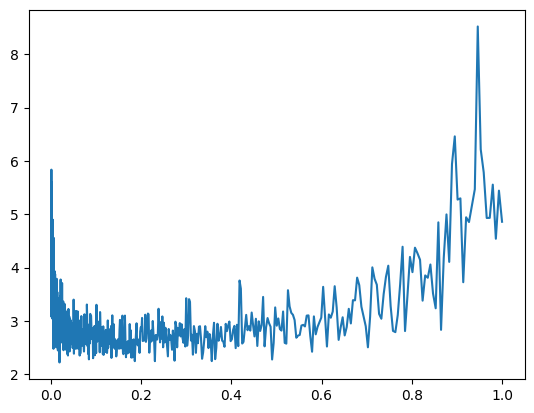

In [494]:
# Optimisation of learning rate code, test 1000 different learning rates from 0.001 to 1, distributed exponentially

lre = torch.linspace(-3, 0, 1000) # 1000 learning rate exponents betwen -3 and 0
lrs = 10**lre # 100 example learning rates spaced between 10^-3 (0.001) and 10^0 (1)
lri = []
lossi = []
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    n = len(ix)
    emb = C[X[ix]]
    # print(emb.shape)
    concat = emb.view(n, 6)
    h = torch.tanh(concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # Entire backward pass:
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -lrs[i] * p.grad

    # track stats
    lri.append(lrs[i])
    lossi.append(loss.item())
print(loss.item())
# This plot shows that the loss is infact minimized around 0.1 for the learning rate, so that was p much optimised anyway
plt.plot(lri, lossi)

In [409]:
# Here's the original forward pass loop, before optimization

for _ in range(5):
    emb = C[X]
    # print(emb.shape)
    
    concat = emb.view(n, 6)
    h = torch.tanh(concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # Entire backward pass:
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad

7.361836910247803
6.842189788818359
6.445642948150635
6.121600151062012
5.852452754974365


In [524]:
# To improve the model further, we need to split our data into training (80%), dev/validation (10%), and test (10%)

# Building out newly structured dataset


def build_dataset(words):
    block_size = 3

    X, Y = [], []
    for w in words:
        chs = ['&'] + list(w) + ['&']
        context = [0] * block_size
        for ch in w + '&':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    n = len(X)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Dataset splits
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [528]:
# This is the model being trained on the training dataset Xtr

for i in range(1000):
    ix = torch.randint(0, Xtr.shape[0], (50,)) # 50 character batch size
    n = len(ix)
    emb = C[Xtr[ix]]
    # print(emb.shape)
    concat = emb.view(n, 6)
    h = torch.tanh(concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Entire backward pass:
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad
        
print(loss.item())

2.5178327560424805


In [529]:
# Tracks the model loss for the dev dataset, so how well our model performs on unseen data
emb = C[Xdev]
n = Xdev.shape[0]
# print(emb.shape)
concat = emb.view(n, 6)
h = torch.tanh(concat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4523730278015137


In [530]:
# other optimisations to try, increasing hidden layer size, increasing embedding dimension from 2 to something bigger than 2

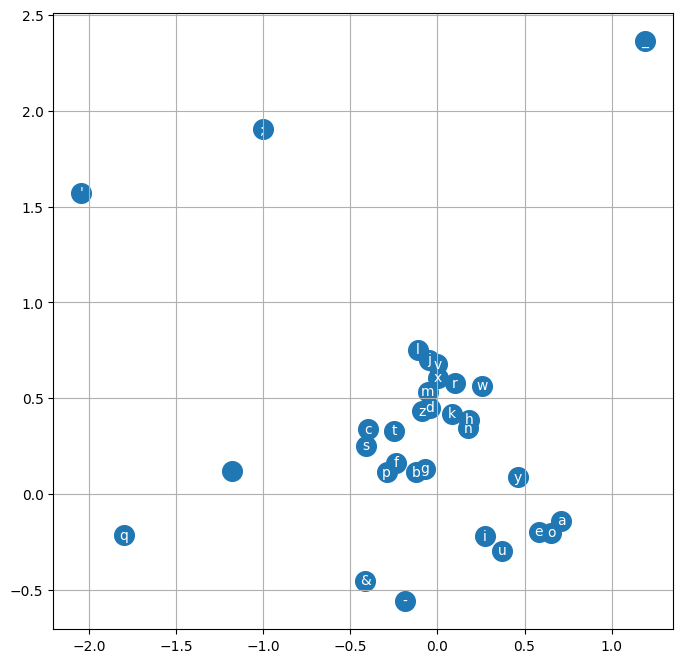

In [537]:
# Lets have a quick look at the current embeddings, as they are 2-dimensional we can view them on a 2-d scatter

plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:

# Knobs to play with and find out the best optimization: 

# Model itself:
# Number of neurons in hidden layer
# Number of dimensions of embedding
# Number of characters in context

# Training Process:
# Number of training iterations (ie 100,000)
# Learning rate (ie 0.1)
# Learning rate decay (ie. switch to 0.01 after 100,000)
# Batch size (number of random examples per training iteration (ie. 50)

# Judging the performance:
# Training dataset loss vs Dev loss: Generally lower is better, both identical = underfitting, both very different = overfitting.